## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

## Imports

In [0]:
!pip install kneed
!pip install lime
!pip install -U sentence-transformers
import os
import re
# avoid using GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')



pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'CNN',
                1:'NYPost'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

     |████████████████████████████████| 276kB 2.7MB/s 
     |████████████████████████████████| 2.0MB 7.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=aa35d127fd364fb2a83c9099b465a0a53e6f935986dd26caf10f4fc10a3b912b
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Successfully built lime
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 573kB 7.7MB/s 
     |████████████████████████████████| 1.0MB 51.0MB/s 
     |████████████████████████████████| 890kB 39.2MB/s 
     |████████████████████████████████| 3.7MB 41.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=01472469e72d75118185d0781202d522305f0c33632bf170412dbece67560c0b
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=84c23825996a98791009ab7be86ec1365407933303748ffa878431e70e62b6c9
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sentence-transformers sacremoses


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Functions

In [0]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Data Prep

## Read CSV

In [0]:
# read reviews from csv file
review_sentiments_df = pd.read_csv('opinionnews.csv', encoding = "ISO-8859-1")
review_sentiments_df = review_sentiments_df.sample(frac=1)
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['article'].values, review_sentiments_df['source'].values
TAG_RE = re.compile(r'<[^>]+>')

for i in range(7507):
    reviews_texts[i] = reviews_texts[i].replace('CNN', '')
    reviews_texts[i] = reviews_texts[i].replace("b'", '')
    reviews_texts[i] = reviews_texts[i].replace("\n", '')
    reviews_texts[i] = TAG_RE.sub('', reviews_texts[i])
    # Remove punctuations and numbers
    #reviews_texts[i] = re.sub('[^a-zA-Z]', ' ', reviews_texts[i])
    # Single character removal
    reviews_texts[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', reviews_texts[i])
    # Removing multiple spaces
    reviews_texts[i] = re.sub(r'\s+', ' ', reviews_texts[i])

# print first 2 examples
review_sentiments_df.head(n=2)

article  source
1773  Why Cindy Hyde-Smith won in MississippiThe GOP scored another midterm Senate win as voters in ruby-red Mississippi elected Republican Cindy Hyde-Smith over Democrat challenger Mike Espy to the United States Senate. While the race was closer than it should have been, there are no moral victories in politics -- win is win. The outcome is significant for two reasons. First, Senator Hyde-Smith becomes the first woman elected to the Senate in Mississippi and her win strengthens the GOP majority in the Senate to 53-47. For state deeply seeded in racial division, this Senate run-off was not about courting white or black voters, it was about turning out red or blue ones. In this conservative Southern state, voters opted for the conservative candidate over the Democrat challenger who campaigned as an independent voice for Mississippi. After declaring victory, Senator Hyde-Smith assured voters that no matter who they voted for, she's "gonna always represent every Mississippian." In classy concession speech, Espy extended his prayers to Hyde-Smith "as she goes to Washington to unite fully divided Mississippi." President Donald Trump won Mississippi in 2016 over Hillary Clinton by nearly 18-point margin. The president is popular there; his policies are popular there. For that reason, Hyde-Smith campaigned as though she and Trump are as close as two coats of red paint and fully supported the Trump agenda. The President traveled to Mississippi Monday to rally the base and tout Hyde-Smith's conservative record. Hyde-Smith campaigned on the issues that appeal to Mississippians: being pro-life, supporting our military, appointing conservatives to the Supreme Court and reigning in federal bureaucracy. But she quickly went from running on offense to being on defense when video surfaced of her telling supporters earlier this month that she would be "on the front row" if one of her supporters invited her "to public hanging." Hyde-Smith apologized to "anyone that was offended" by her comments. It was not full-throated apology, but the trust and respect she has built up over her nearly two decades in public service went long way towards helping her weather the political storm. Black Republican Charlie Evers, brother of slain civil rights leader Medgar Evers, defended Hyde-Smith, adding he "don't give damn what other people think." Espy is former congressman who also served as Agriculture Secretary under President Bill Clinton. He campaigned as an Independent, yet as President Trump reminded voters, Espy supports the "Democrat agenda of socialism and open borders." As member of Congress, Espy voted with the Democratic Party 91% of the time and told supporters he would caucus with Senate Minority Leader Chuck Schumer. Perhaps many voters took note of neighboring Senator Doug Jones, who campaigned for Espy. The Alabama Democrat ran against Republican Roy Moore who was accused of sexual misconduct with minors. Jones won in December of 2017, in large part by claiming he would serve as conservative. However, since taking office Senator Jones has been reliable vote for the Democratic agenda, including his vote against Judge Brett Kavanaugh. Voters in Mississippi made it clear they support the McConnell direction of this country, not the Schumer direction. They support the conservative political record of Hyde-Smith under President Trump's leadership. Like it or not, the expected outcome occurred in Mississippi, giving the GOP valuable increased margin needed to put further pressure on Democrats.                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## BERT Embeddings

In [0]:
# load for future predicitons
embedding_model = SentenceTransformer(model_name_or_path='bert-base-nli-mean-tokens',
                                    device=torch.device('cpu'))
# load embeddings for all reviews
#reviews_embeddings_part1 = np.load('../data/movies_reviews_embeddings_part1.npy')
#reviews_embeddings_part2 = np.load('../data/movies_reviews_embeddings_part2.npy')
# concatenate parts
#reviews_embeddings = np.concatenate((reviews_embeddings_part1, reviews_embeddings_part2))
reviews_embeddings  = embedding_model.encode(sentences=reviews_texts, 
                                          batch_size=500, 
                                          show_progress_bar=True)
reviews_embeddings = np.array(reviews_embeddings)

print('Bert Embeddings Loaded: ', reviews_embeddings.shape)

100%|██████████| 405M/405M [00:17<00:00, 23.4MB/s]
Batches: 100%|██████████| 16/16 [50:45<00:00, 190.36s/it]

Bert Embeddings Loaded:  (7507, 768)


# Simple Neural Network

## Config

In [0]:
EMBEDDING_SIZE = 768
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [0]:
# split train 80% - test 20% 
embeddings_train, embeddings_test, sentiments_train, sentiments_test = train_test_split(reviews_embeddings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
embeddings_train, embeddings_valid, sentiments_train, sentiments_valid = train_test_split(embeddings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', embeddings_train.shape)
print('Validation shape:', embeddings_valid.shape)
print('Test shape:      ', embeddings_test.shape)

Train shape:      (5404, 768)
Validation shape: (601, 768)
Test shape:       (1502, 768)


## Data Generators

In [0]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((embeddings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((embeddings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                12304     
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
11/11 [==============================] - 0s 18ms/step - loss: 1.4520 - accuracy: 0.4978 - val_loss: 0.7118 - val_accuracy: 0.5208
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 1.1218 - accuracy: 0.5516 - val_loss: 0.6094 - val_accuracy: 0.6656
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.6619 - val_loss: 0.5591 - val_accuracy: 0.7188
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.9082 - accuracy: 0.

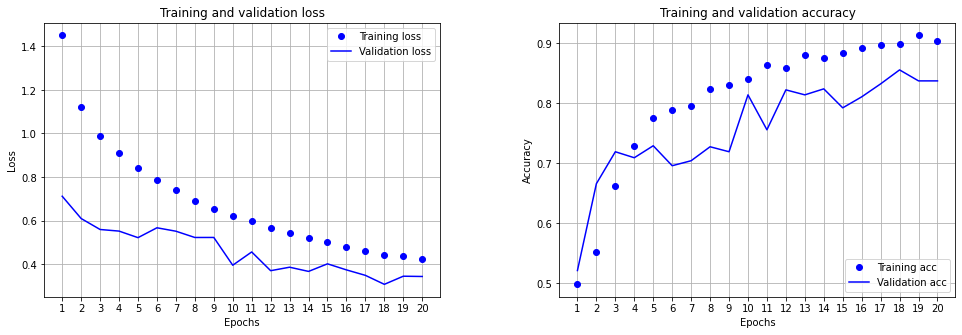

In [0]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(EMBEDDING_SIZE,), activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
class_weight = {0: 1.,
                1: 6.}
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1, class_weight=class_weight)
# plot training curves
plt_history(history_dict=history.history)

## Evaluation

In [0]:
# get model predicitons
sentiments_predicitons = model.predict_classes(embeddings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1228
           1       0.64      0.88      0.74       274

    accuracy                           0.89      1502
   macro avg       0.80      0.88      0.83      1502
weighted avg       0.91      0.89      0.89      1502



## Explain Model

In [0]:
example_sample = 'Movie was great! I hate it!'

# explain model prediciton
def classifier_dn(texts):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  encodings_texts = embedding_model.encode(sentences=texts, 
                                          batch_size=500, 
                                          show_progress_bar=True)
  encodings_texts = np.array(encodings_texts)
  for encoding_text in encodings_texts:
    preds = model(encoding_text.reshape(1,768))[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(example_sample,  classifier_dn, num_features=EMBEDDING_SIZE)
# output to cell
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
Batches: 100%|██████████| 10/10 [01:50<00:00, 11.05s/it]


# Run Best k-means model

In [0]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [0]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
#     cluster_plot.savefig("pca_plot.png")
  return reduced_features

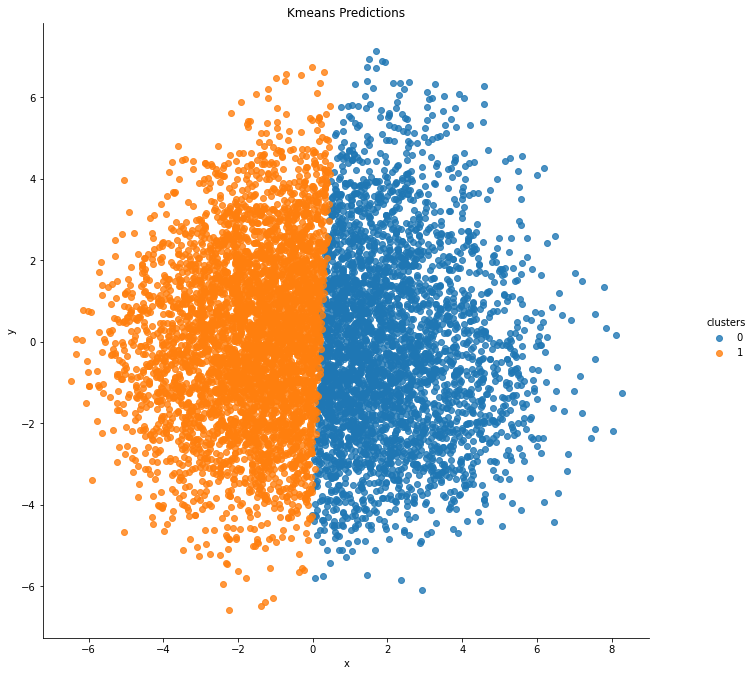

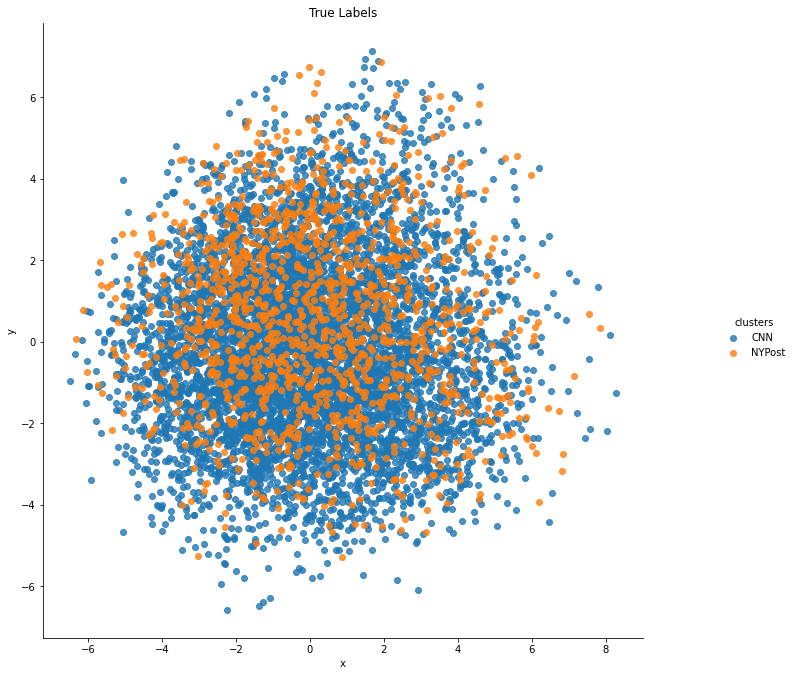



Found labels: [0, 1]



labels         cluster_match
0  0       CNN:2743  NYPost:607
1  1       CNN:3402  NYPost:755

In [0]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [0]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels         cluster_match
0  0       CNN:2400  NYPost:444
1  1       CNN:1957  NYPost:375
2  2       CNN:1788  NYPost:543

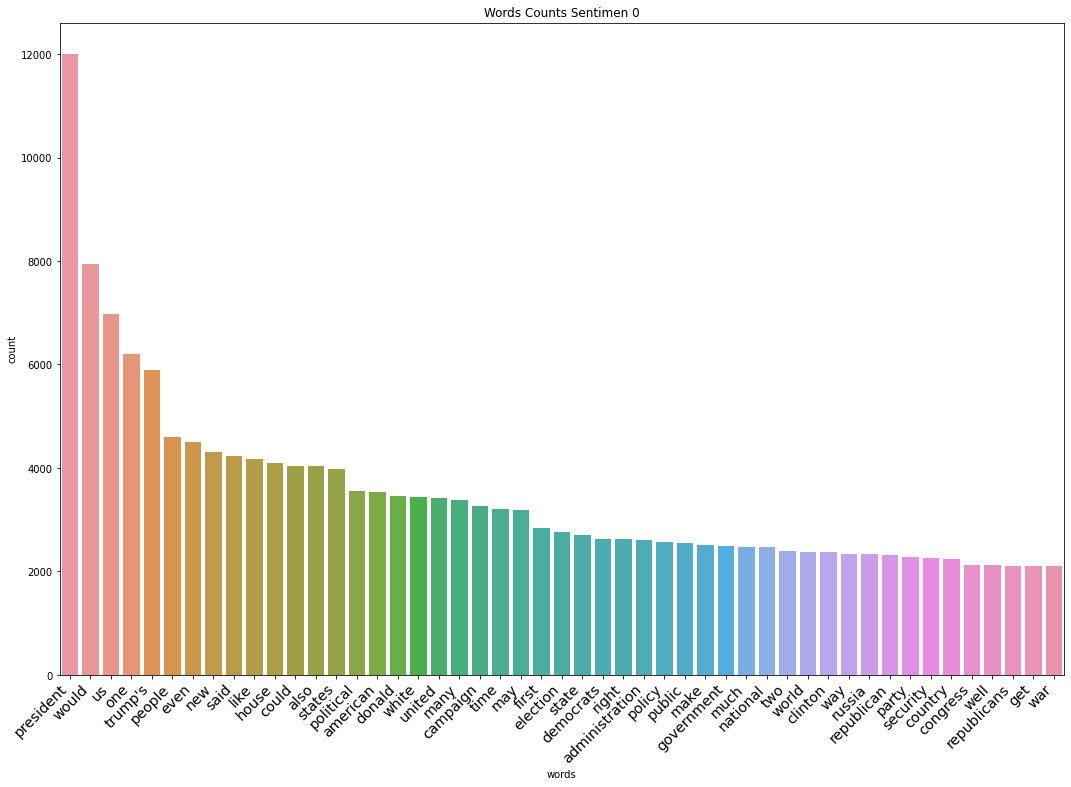

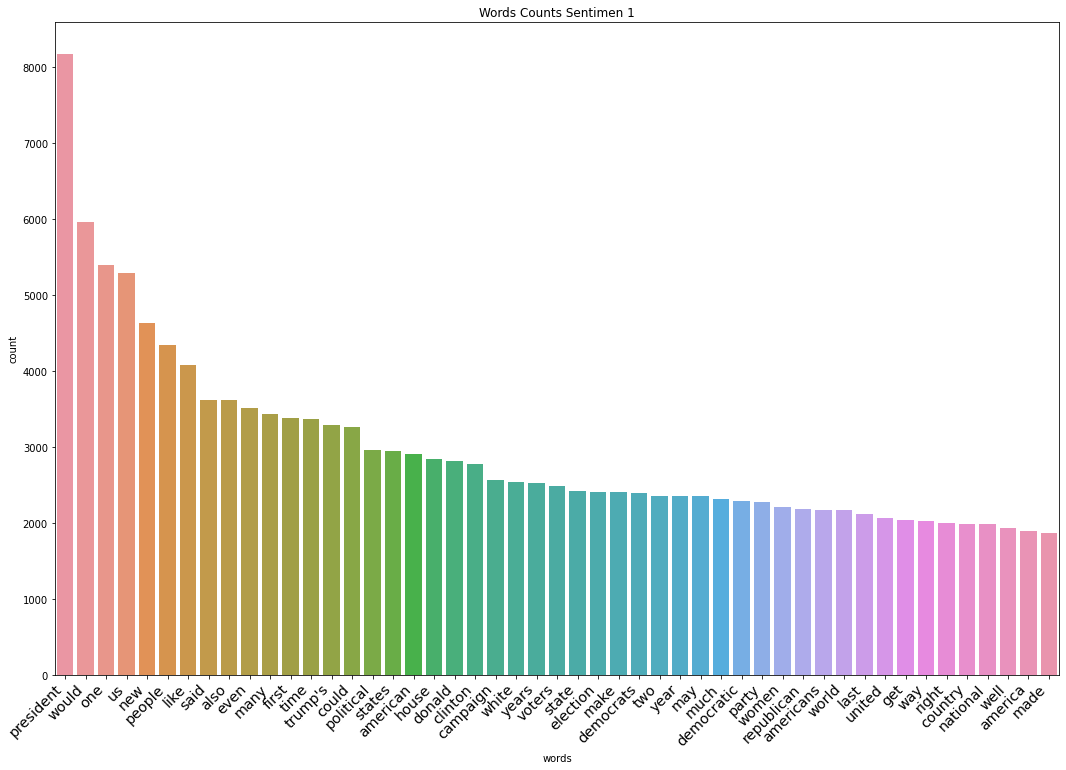

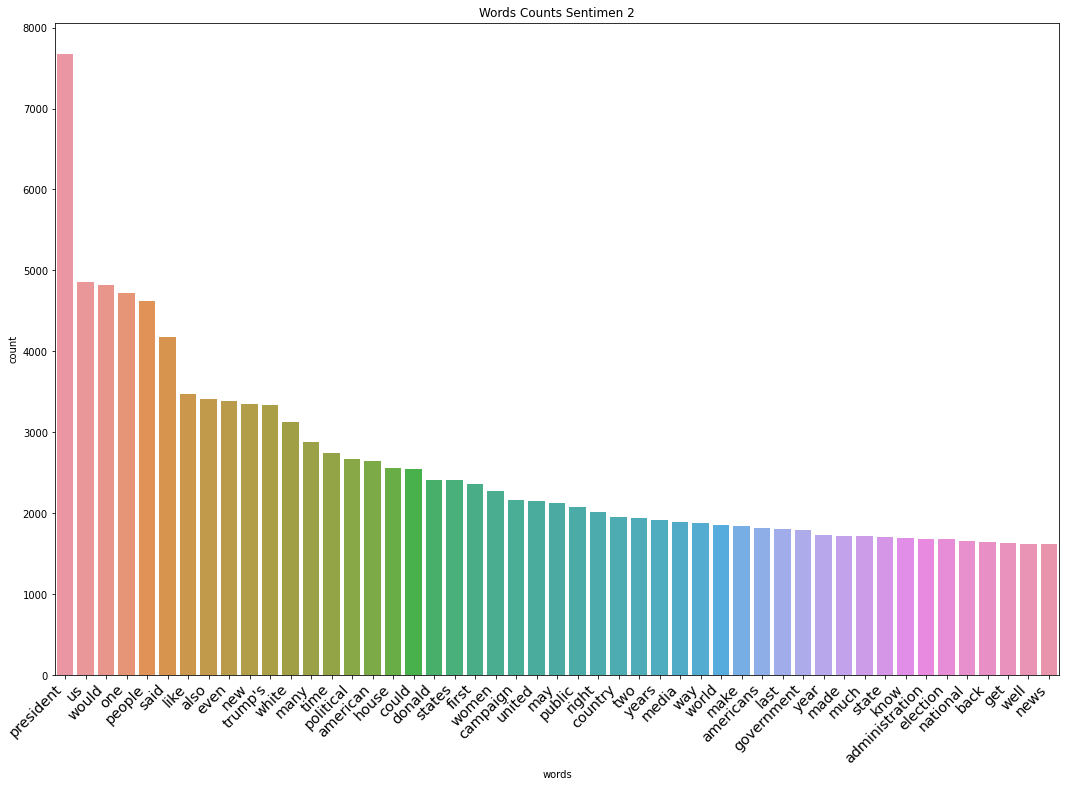

In [0]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

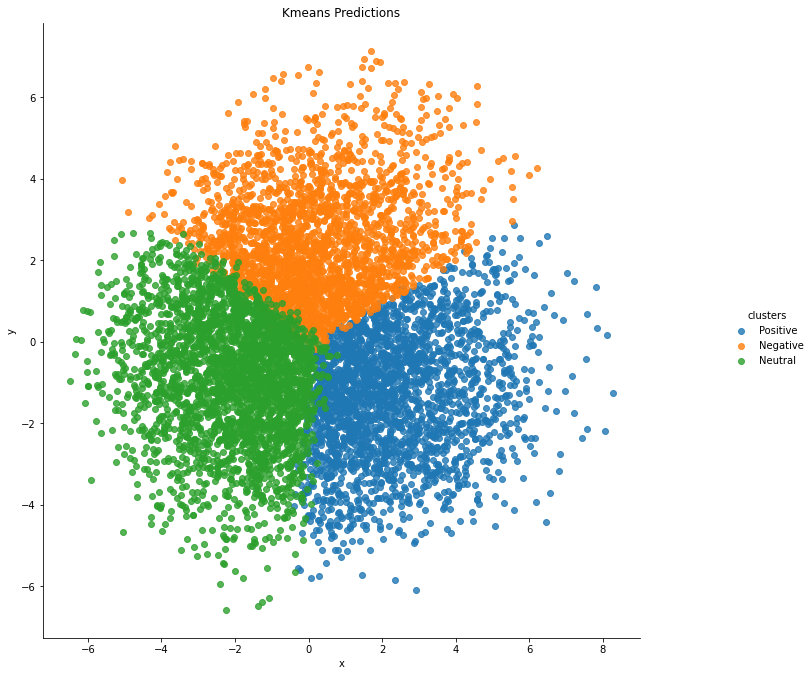

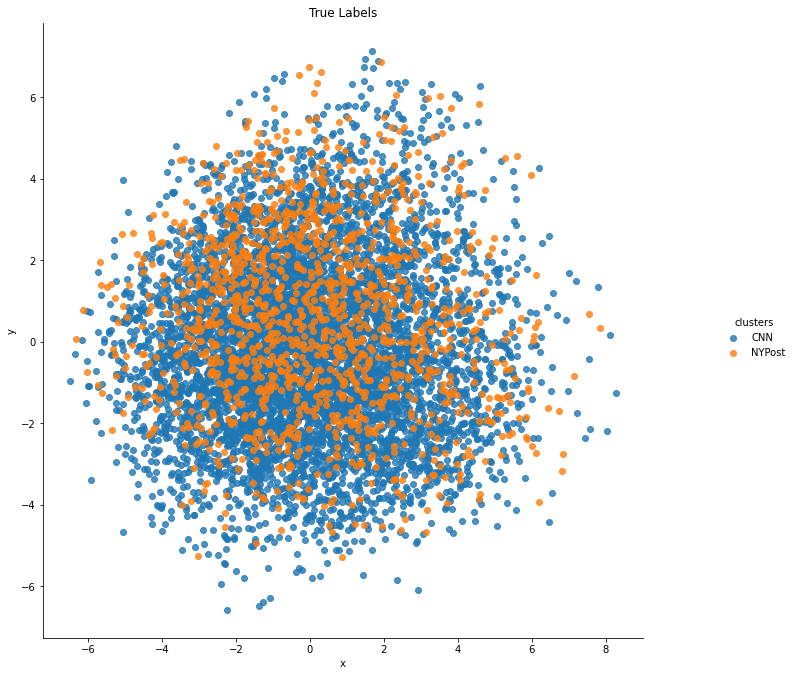

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  Melania Trump's dangerous move\nBy all accounts, Mira Ricardel has not made a lot of friends in the Trump administration. A key member of national security adviser John Bolton's team, she was brought in in April to help him shake up the national security staff. In the past, she had butted heads with Secretary of Defense Jim Mattis, and chief of staff John Kelly is reportedly not a fan, two former White House officials told the Washington Post. Now it appears that she has learned, quite publicly, that the one you really don't want to mess with is the first lady. In another episode of "Survivor: West Wing," Melania Trump went public Tuesday with her personnel concerns about Ricardel, in the process undermining the national security staff and -- not to be forgotten -- our national security. Indeed  reported Tuesday afternoon that "a White House official confirmed ... that Trump has told people that Ricardel will be fired, but she has been given some time to clear out her desk." The once private dispute between the first lady, her staff and Ricardel broke into the open this week after news reports that Ricardel had challenged some request from the first lady's office about Melania Trump's recent trip to Africa.  reported that a person familiar with the most recent dustup said "Ricardel quarreled with the first lady's staff over seating on the plane and use of National Security Council resources." Melania Trump's spokeswoman issued a statement Tuesday that "(i)t is the position of the office of the first lady that she [Ricardel] no longer deserves the honor of serving in this White House." So, let me make a few things clear. First, Ricardel may have been behaving badly regarding the Africa trip; there are some suggestions in news reports that she deliberately withheld national security resources from the first lady's office. Second, Melania Trump has every right to relate her disdain for bad behavior to her husband or Bolton and to ask for a staffer's resignation over not sufficiently respecting the first lady's duties. But what is not acceptable, and indeed dangerous, is the extent to which Melania Trump used her status as a family member  unelected, unappointed and unqualified  to dictate national security personnel decisions, in public, as if there are no global consequences to such action. And, in this regard, the first lady was acting very -- Trumpish. There is a great deal of this sort of behavior in this White House  the people's house. The President, her husband, wants a military parade (eventually). Jared Kushner, Melania Trump's son-in-law, wants to guide Middle East politics while continuing his business deals with those very same nations. Earlier in the administration, Ivana Trump, Melania Trump's husband's ex-wife, said she was considered for (and turned down) the post of ambassador to the Czech Republic. And Ivanka Trump, her daughter-in-law, just received initial approval for 16 new trademarks from China, while experts on trade are trying to avoid a tariff war. All these are examples where the line between national security and Trump family interest are blurred, if not essentially invisible. There are no American interests for the first family, only Trump personal or financial interests. And there is likely to be more drama poured into the security mix in coming days. Sources in the White House made it clear Tuesday that Secretary of Homeland Security Kirstjen Nielsen's days in her job are numbered. And John Kelly, the chief of staff, may also be booted, sources told . Melania Trump's actions are consistent with the mercurial management preferences of the Trump family; indeed, the President is keen on calling the defense apparatus that exists to protect America "my generals." The family has turned national security -- once, not so long ago, immune from the political backstabbing and favor-grabbing that animate the political side of the White House -- into its own TV-style drama. T

## k=4 sentiments

In [0]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels         cluster_match
0  0       CNN:1795  NYPost:331
1  1       CNN:1533  NYPost:399
2  2       CNN:1141  NYPost:374
3  3       CNN:1676  NYPost:258

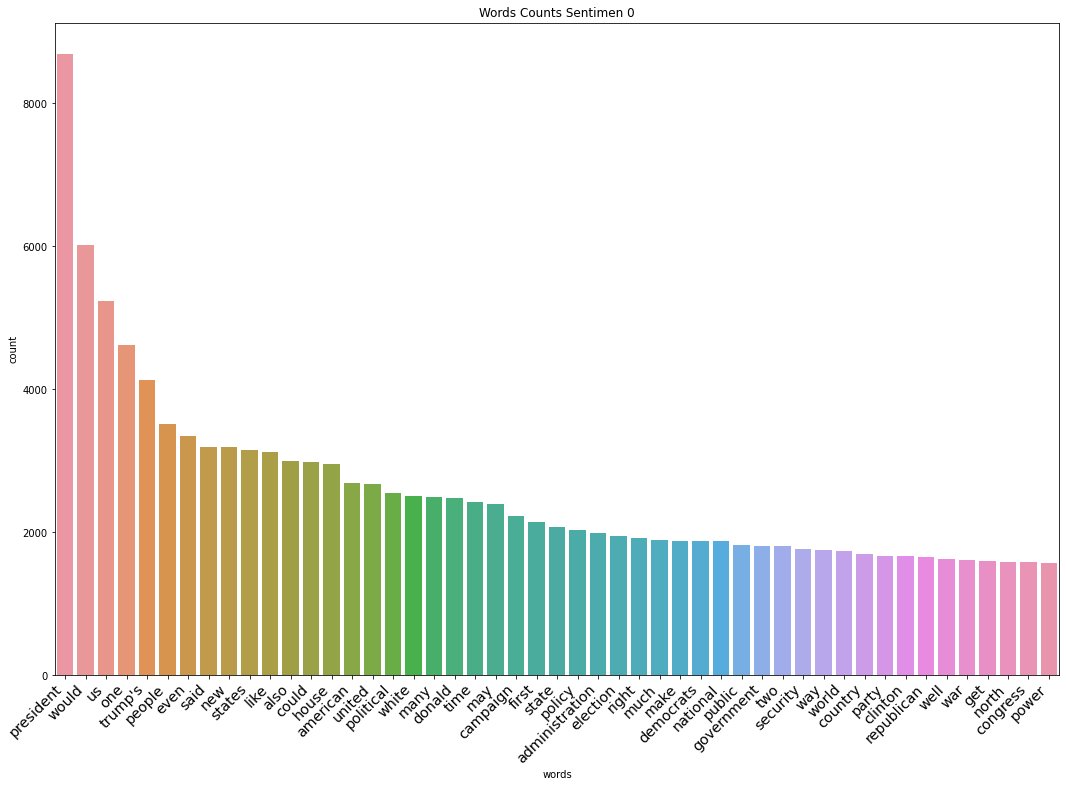

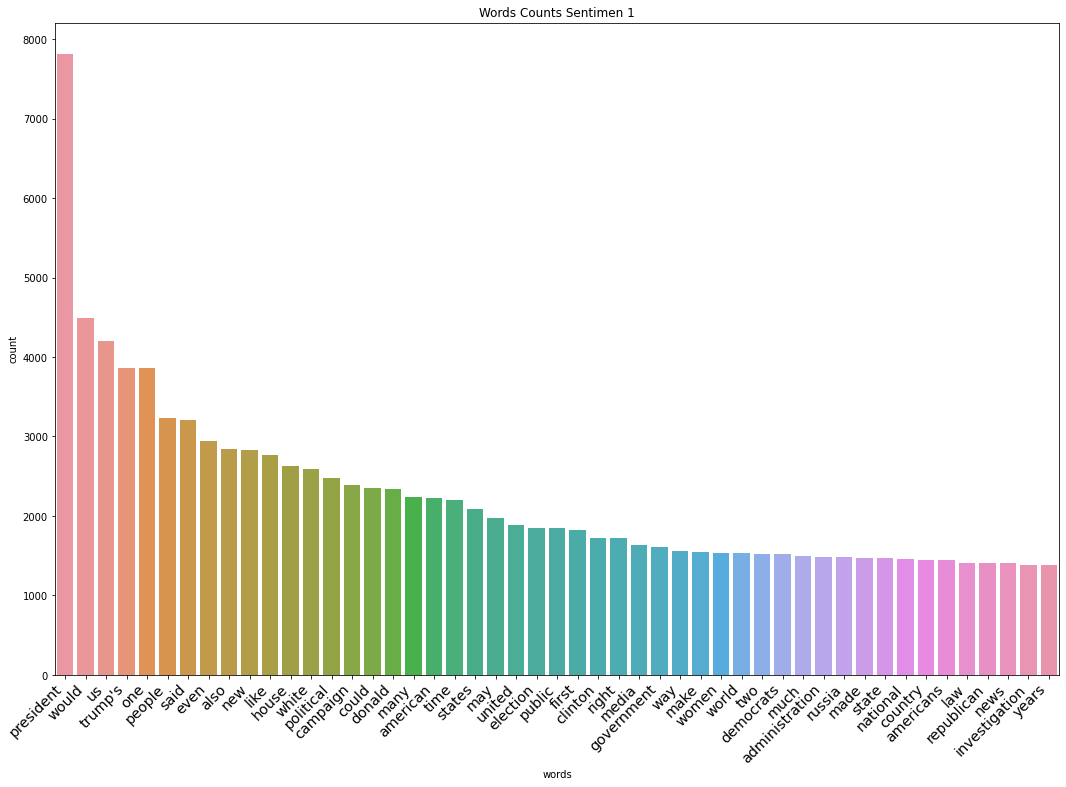

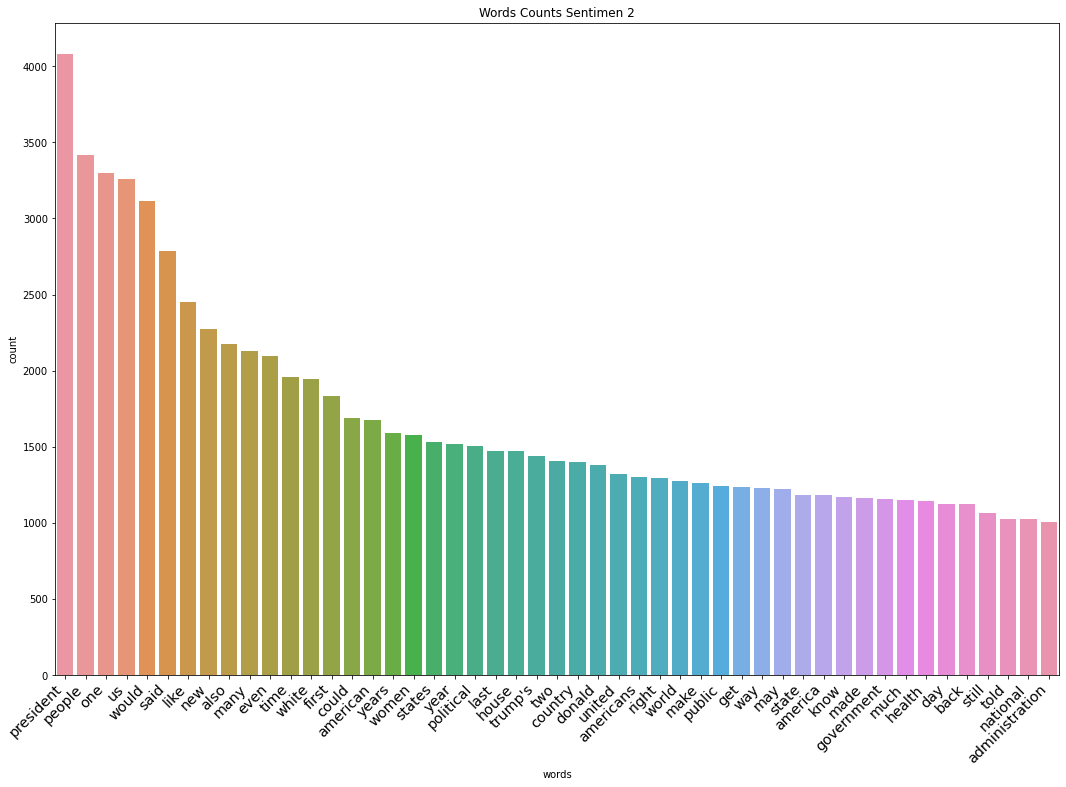

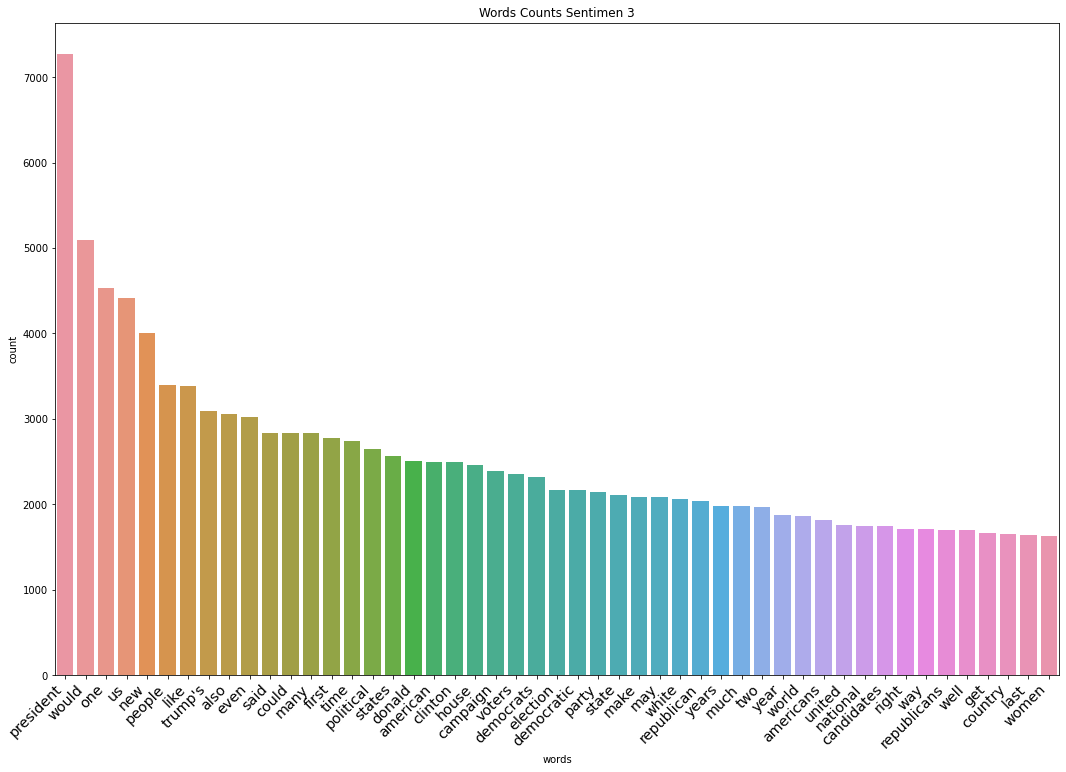

In [0]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

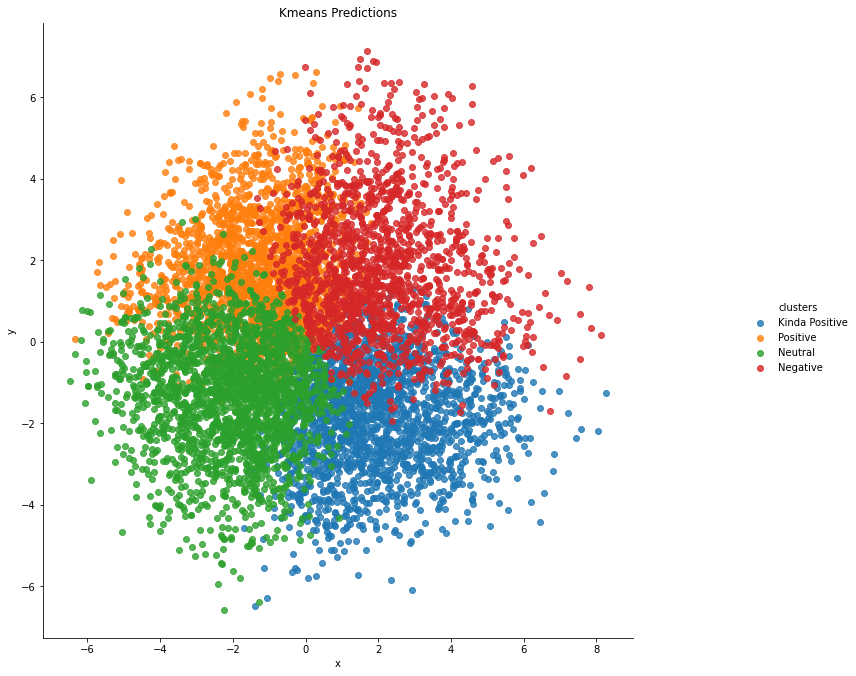

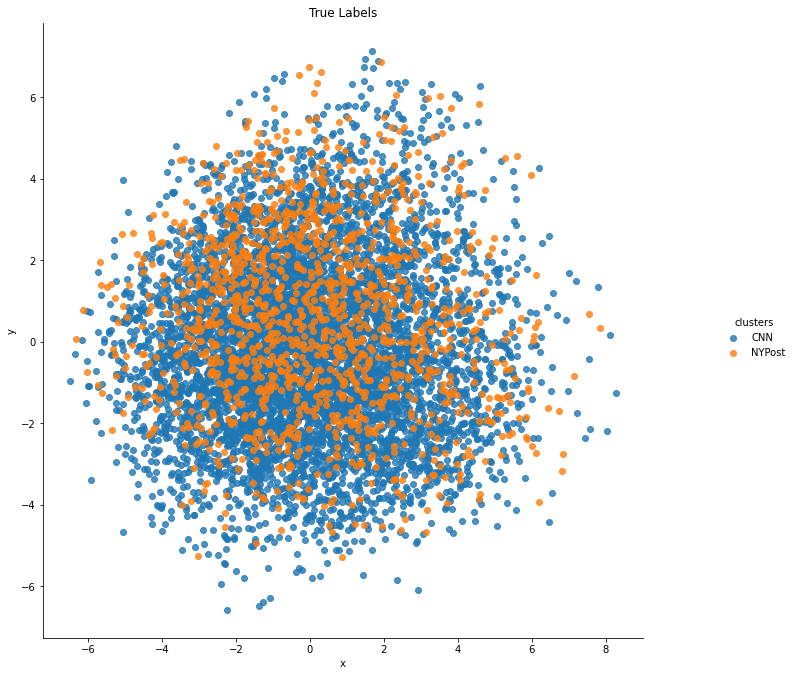

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  ... Prediction Sentiment
0  Are Tillerson's days numbered?\nSecretary of State Rex Tillerson made a remarkable statement on Wednesday, rejecting reports he had considered resigning and reaffirming his commitment to the President's domestic and foreign policies. This was both stunning and unprecedented. It was not quite a hostage video, but it seemed awkward that a secretary of state felt compelled to defend himself in response to a press report. Indeed, Tillerson has good instincts on many foreign policy issues and is ready to provide independent advice. But his road ahead won't be easy, particularly given that Donald Trump is ready and willing to undercut him. Still, Tillerson clearly doesn't plan to resign, despite an NBC report that he referred to the President as a "moron" -- a claim his spokeswoman denies. And even if he did, it might not matter much who succeeded him. Unless the bureaucratic environment in Trumpland changes, his successor will likely confront the same challenges Tillerson is facing now. So, what are these challenges? First, our decades of experience in the Department of State allow us to report that the dynamic playing out now between the President and Tillerson has not existed before in modern US foreign policy history. Granted, Tillerson has not helped himself. He was not necessarily the President's first choice, lacks Washington experience, has an aversion to the media and has some misplaced priorities in how he has tried to reform the State Department. But none of this can explain the current level of dysfunction that exists between the two. Secretaries of state and presidents have argued privately before over process and substance. But it's rare -- indeed unprecedented -- that these differences surface publicly. In the modern period, only two secretaries of state have resigned over principle: William Jennings Bryan in 1915, over Woodrow Wilson's policies toward Germany in the run-up to World War I, and Cyrus Vance in 1980, in opposition to Jimmy Carter's efforts to rescue the American hostages in Iran. And that there is serious talk of Tillerson's resignation less than 10 months into his tenure is shocking. Since the 1950s, only two secretaries of state have had significantly abbreviated tenures: Edmund Muskie, who served out the remainder of Vance's term, and Alexander Haig, who left early because of inter-cabinet tensions generated by his brash style. While Muskie served just shy of a year, Haig served for a year and a half before his departure. Second, that the President would mishandle and undermine his secretary of state at a time when the world is filled with foreign policy challenges -- indeed crises that require 24/7 focus and attention -- is also without precedent. And whatever Tillerson's flaws and failings, when it comes to matters of substance, such as recertifying the Iran deal, not picking sides in the Saudi-Qatar cold war, or probing diplomatic options on North Korea, his instincts are far sounder than the President's. And yet Trump has consistently undermined -- even humiliated -- his top diplomat on these issues, most recently tweeting that Tillerson was wasting his time on North Korea. It would be one thing if the President were experienced in foreign policy or had other advisers who had both experience and influence on these issues. Both Secretary of Defense James Mattis and National Security Adviser HR McMaster have plenty of experience (though in national security and war-making -- not in diplomacy). But even their influence is limited. President Richard Nixon and National Security Advisor Henry Kissinger cut Secretary of State William Rogers out of many of the decisions on China and the Middle East. But they had the experience to make foreign policy decisions. Unfortunately, there is no other go-to person with diplomatic experience in Trump's administration. Third, whatever responsibility Tillerson bears for his own misfortunes, he simply cannot function effectively as th

# Custom Samples

In [0]:
custom_text = "This workshop roks!!"

encodings_texts = embedding_model.encode(sentences=[custom_text], 
                                          batch_size=1, 
                                          show_progress_bar=True)
encodings_texts = np.array(encodings_texts)
kmean_label = kmean_model.predict(tf.get_static_value(encodings_texts))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]

Text:  This workshop roks!!
Sentiment:  Positive
